<a href="https://colab.research.google.com/github/CharFox1/CompVisProj/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
from torch import nn, tensor
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as T
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!unzip handwrittenChars.zip

Archive:  handwrittenChars.zip
   creating: handwrittenChars/
   creating: handwrittenChars/.ipynb_checkpoints/
  inflating: handwrittenChars/.ipynb_checkpoints/parseHandwrittenChars-checkpoint.ipynb  
  inflating: handwrittenChars/parseHandwrittenChars.ipynb  
  inflating: handwrittenChars/trainSmall.npy  
  inflating: handwrittenChars/valSmall.npy  


In [36]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [18]:
# Manually pick cpu device if desired
device = "cpu"

In [37]:
# resnet block to be used in models below
# code modified from "resnet-34-pytorch-starter-kit"

class resBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, padding=1, bias=False):
    super(resBlock, self).__init__()
    
    self.cnn1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(True)
    )

    self.cnn2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding, bias=False),
        nn.BatchNorm2d(out_channels)
    )

    # if the output image will be a different size than the input
    # must reshape residual to fit new output shape
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels)
      )
    # otherwise just pass it through 
    else:
      self.shortcut = nn.Sequential()

  def forward(self, x):
    residual = x
    x = self.cnn1(x)
    x = self.cnn2(x)
    x += self.shortcut(residual)
    x = nn.ReLU(True)(x)
    return x


In [38]:
# simple conv network to test finding single characters
# uses resnet structure

class convDemoNet(nn.Module):
  def __init__(self, numClasses):
    super(convDemoNet, self).__init__()
    
    self.block1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=2, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True)
    )

    self.block2 = nn.Sequential(
        nn.MaxPool2d(1, 1),
        resBlock(64, 64),
        resBlock(64, 64, 2)
    )

    self.block3 = nn.Sequential(
        resBlock(64, 128),
        resBlock(128, 128, 2)
    )

    self.block4 = nn.Sequential(
        resBlock(128, 256),
        resBlock(256, 256, 2)
    )

    self.block5 = nn.Sequential(
        resBlock(256, 512),
        resBlock(512, 512, 2)
    )

    self.avgpool = nn.AvgPool2d(2)
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(512, 512)
    self.l2 = nn.Linear(512, 256)
    self.l3 = nn.Linear(256, numClasses)
    #self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.avgpool(x)
    x = self.flatten(x)
    x = self.l1(x)
    x = self.l2(x)
    x = self.l3(x)
    return x

In [39]:
# small function to turn int index into one hot encoding
def oneHot(num, numClasses):
  output = [0] * numClasses
  output[num] = 1
  return output

training data size: 78000
validation data size: 13209
training data shape: (32, 32)


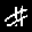

data type of image = <class 'numpy.ndarray'>
training data label: #
each index in dataset has image (32x32) and char label
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [40]:
# get conv demo data (https://www.kaggle.com/vaibhao/handwritten-characters)
from google.colab.patches import cv2_imshow #allows us to show images

# grab small files (created from larger dataset)
# this is the location they should be in the github
# if you are running in collab, you need to import the handwrittenChars folder as a zip
# you can unzip it with "!unzip handwrittenChars.zip" in a separate cell
with open("handwrittenChars/trainSmall.npy", "rb") as f:
    conv_train_data = np.load(f, allow_pickle=True)

with open("handwrittenChars/valSmall.npy", "rb") as f:
    conv_val_data = np.load(f, allow_pickle=True)

print("training data size:", len(conv_train_data))
print("validation data size:", len(conv_val_data))

print("training data shape:", conv_train_data[1201][0].shape)
cv2_imshow(conv_train_data[1201][0])
print("data type of image =", type(conv_train_data[1201][0]))
print("training data label:", conv_train_data[1201][1])
print("each index in dataset has image (32x32) and char label")
print(conv_train_data[1201][0])

In [41]:
labels = []
for i in conv_train_data:
  label = i[1]
  if label not in labels:
    labels.append(label)

print("there are", len(labels), "labels in the training dataset")

for i in conv_val_data:
  label = i[1]
  if label not in labels:
    labels.append(label)

print("there are", len(labels), "labels in the validation dataset")

labelDict = {}
for i in range(len(labels)):
  labelDict[i] = labels[i]

print(labelDict)
invertedLabelDict = {y:x for x,y in labelDict.items()}
print(invertedLabelDict)

there are 39 labels in the training dataset
there are 39 labels in the validation dataset
{0: '#', 1: '$', 2: '&', 3: '0', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6', 10: '7', 11: '8', 12: '9', 13: '@', 14: 'A', 15: 'B', 16: 'C', 17: 'D', 18: 'E', 19: 'F', 20: 'G', 21: 'H', 22: 'I', 23: 'J', 24: 'K', 25: 'L', 26: 'M', 27: 'N', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z'}
{'#': 0, '$': 1, '&': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '@': 13, 'A': 14, 'B': 15, 'C': 16, 'D': 17, 'E': 18, 'F': 19, 'G': 20, 'H': 21, 'I': 22, 'J': 23, 'K': 24, 'L': 25, 'M': 26, 'N': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38}


In [42]:
# dataset class
class handwrittenCharsDataset(Dataset):
    def __init__(self, X, classToNum):
      self.classToNum = classToNum
      self.images = []
      self.labels = []
      for i in X:
        self.images.append(i[0])
        self.labels.append(i[1])

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, index):
      image = self.images[index]
      label = tensor(self.classToNum[self.labels[index]])
      #label = tensor(oneHot(labelNum, 39))
      image = self.transform(image)
      sample = [image, label]
      return sample
    
    transform = T.Compose([
      T.ToPILImage(),
      T.ToTensor()                     
    ])

In [43]:
batch_size = 10
dataset = handwrittenCharsDataset(X=conv_train_data, classToNum=invertedLabelDict)
train_dl = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)

tensor([29, 21, 25, 15,  3, 11,  0, 10, 17, 24])
Feature batch shape: torch.Size([10, 1, 32, 32])
Labels batch shape: torch.Size([10])


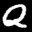

predicted & for Q


In [44]:
# init model with 39 classes on output layer
# put model in gpu if available
convModel = convDemoNet(39).to(device)
#print(convModel)

testItem, testLabel = next(iter(train_dl))
print(testLabel)
print(f"Feature batch shape: {testItem.size()}")
print(f"Labels batch shape: {testLabel.size()}")

testItem = testItem[0].unsqueeze(0).to(device)
#testLabel = labelDict[testLabel[0].numpy().argmax()]
testLabel = labelDict[testLabel.numpy()[0]]

# some funny business to get image from tensor to see if guess is reasonable
image = testItem[0].cpu().numpy()[0] * 255
cv2_imshow(image)

output = convModel(testItem)
y_pred = labelDict[output.argmax(1).item()]
print("predicted", y_pred, "for", testLabel)

In [15]:
!pip install hiddenlayer

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


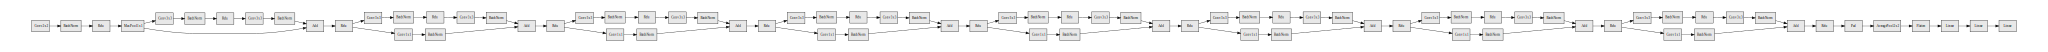

In [33]:
# Need to be in cpu to render this image
import hiddenlayer as hl

hl.build_graph(convModel, torch.zeros([1, 1, 32, 32]), transforms=transforms)

In [45]:
def findAccuracy(outputs, labels):
  accuracy = 0
  for i in range(len(outputs)):
    if outputs[i].cpu().detach().numpy().argmax() == labels[i]:
      accuracy += 1

  return (accuracy/len(outputs))


In [46]:
import torch.optim as optim
lossFunc = nn.CrossEntropyLoss()
opt = optim.SGD(convModel.parameters(), lr=0.001) 

num_epochs = 10

testLoss = []
testAcc = []

for epoch in range(num_epochs):
  running_loss = 0
  running_acc = 0
  for i, data in enumerate(train_dl, 0):
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    
    opt.zero_grad()

    outputs = convModel(images)

    loss = lossFunc(outputs, labels)
    loss.backward()
    opt.step()

    running_acc += findAccuracy(outputs, labels)

    running_loss += loss.item()
    if i % 1000 == 999:
      testLoss.append(running_loss)
      testAcc.append(running_acc/10)
      print("[%d, %5d] loss: %.5f acc: %.3f%%" % (epoch + 1, i + 1, running_loss / 1000, running_acc / 10))
      running_loss = 0
      running_acc = 0

print("Done!")

[1,  1000] loss: 3.45826 acc: 23.290%
[1,  2000] loss: 2.38822 acc: 54.700%
[1,  3000] loss: 1.26932 acc: 74.540%
[1,  4000] loss: 0.74823 acc: 82.420%
[1,  5000] loss: 0.54507 acc: 85.460%
[1,  6000] loss: 0.44735 acc: 87.180%
[1,  7000] loss: 0.37793 acc: 88.790%
[2,  1000] loss: 0.29403 acc: 90.640%
[2,  2000] loss: 0.28358 acc: 91.050%
[2,  3000] loss: 0.28380 acc: 91.160%
[2,  4000] loss: 0.25971 acc: 91.640%
[2,  5000] loss: 0.25162 acc: 91.820%
[2,  6000] loss: 0.25103 acc: 91.480%
[2,  7000] loss: 0.24592 acc: 91.750%
[3,  1000] loss: 0.19664 acc: 93.050%
[3,  2000] loss: 0.19014 acc: 93.590%
[3,  3000] loss: 0.19829 acc: 93.230%
[3,  4000] loss: 0.18710 acc: 93.290%
[3,  5000] loss: 0.19220 acc: 93.110%
[3,  6000] loss: 0.18330 acc: 93.570%
[3,  7000] loss: 0.18261 acc: 93.600%
[4,  1000] loss: 0.15282 acc: 94.470%
[4,  2000] loss: 0.15773 acc: 94.330%
[4,  3000] loss: 0.16253 acc: 94.010%
[4,  4000] loss: 0.15957 acc: 94.240%
[4,  5000] loss: 0.15210 acc: 94.410%
[4,  6000] l

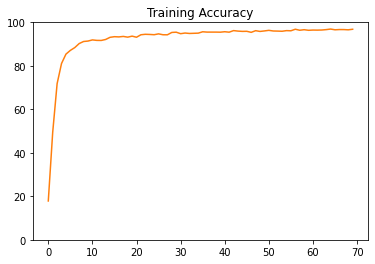

In [160]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(testAcc, color="tab:orange")
ax.set_ylim([0,100])
ax.set_title("Training Accuracy")
plt.show()

In [161]:
batch_size = 10
dataset = handwrittenCharsDataset(X=conv_val_data, classToNum=invertedLabelDict)
val_dl = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)

In [163]:
valLoss = []
valAcc = []

for epoch in range(3):
  running_loss = 0
  running_acc = 0
  for i, data in enumerate(val_dl, 0):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    outputs = convModel(images)

    running_acc += findAccuracy(outputs, labels)

    running_loss += loss.item()
    if i % 1000 == 999:
      valLoss.append(running_loss)
      valAcc.append(running_acc/10)
      print("[%d, %5d] loss: %.5f acc: %.3f%%" % (epoch + 1, i + 1, running_loss / 1000, running_acc / 10))
      running_loss = 0
      running_acc = 0

print("Done!")

[1,  1000] loss: 0.05703 acc: 77.750%
[2,  1000] loss: 0.05703 acc: 77.780%
[3,  1000] loss: 0.05703 acc: 77.290%
Done!


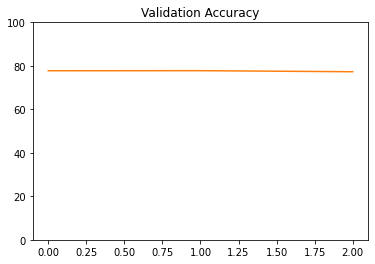

In [164]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(valAcc, color="tab:orange")
ax.set_ylim([0,100])
ax.set_title("Validation Accuracy")
plt.show()

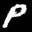

predicted P for P


In [132]:
testItem, testLabel = next(iter(val_dl))

testItem = testItem[0].unsqueeze(0).to(device)
testLabel = labelDict[testLabel[0].item()]

output = convModel(testItem)
# some funny business to get image from tensor to see if guess is reasonable
image = testItem[0].cpu().numpy()[0] * 255
cv2_imshow(image)
y_pred = labelDict[output.argmax(1).item()]
print("predicted", y_pred, "for", testLabel)

original image


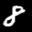

corner detection


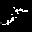

original scaled by corner probabilities


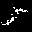

In [12]:
# experiment with effects of harris corner detection
print("original image")
input = np.float32(conv_train_data[22001][0])
cv2_imshow(input)
out = cv2.cornerHarris(input, 2, 3, 0.04)
print("corner detection")
cv2_imshow(out)
combined = input * out
print("original scaled by corner probabilities")
cv2_imshow(combined)

In [15]:
# dataset class with corner detection added (may make things more difficult)
class handwrittenCharsCornerDataset(Dataset):
    def __init__(self, X, classToNum):
      self.classToNum = classToNum
      self.images = []
      self.labels = []
      for i in X:
        self.images.append(i[0])
        self.labels.append(i[1])

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, index):
      # apply corner detection to image
      image = np.float32(self.images[index])
      image = image * cv2.cornerHarris(image, 2, 3, 0.04)

      label = tensor(self.classToNum[self.labels[index]])
      image = self.transform(image)
      sample = [image, label]
      return sample
    
    transform = T.Compose([
      T.ToPILImage(),
      T.ToTensor()                     
    ])

In [19]:
batch_size = 10
dataset = handwrittenCharsCornerDataset(X=conv_train_data, classToNum=invertedLabelDict)
cornerTrain_dl = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)

tensor([ 6, 19, 12,  8, 27, 26,  4, 31,  9, 10])
Feature batch shape: torch.Size([10, 1, 32, 32])
Labels batch shape: torch.Size([10])


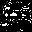

predicted G for 3


In [34]:
# init new model to use corner detection version of dataset
cornerConvModel = convDemoNet(39).to(device)
#print(convModel)

testItem, testLabel = next(iter(cornerTrain_dl))
print(testLabel)
print(f"Feature batch shape: {testItem.size()}")
print(f"Labels batch shape: {testLabel.size()}")

testItem = testItem[0].unsqueeze(0).to(device)
#testLabel = labelDict[testLabel[0].numpy().argmax()]
testLabel = labelDict[testLabel.numpy()[0]]

# some funny business to get image from tensor to see if guess is reasonable
image = testItem[0].cpu().numpy()[0] * 255
cv2_imshow(image)

output = cornerConvModel(testItem)
y_pred = labelDict[output.argmax(1).item()]
print("predicted", y_pred, "for", testLabel)

In [36]:
import torch.optim as optim
lossFunc = nn.CrossEntropyLoss()
opt = optim.SGD(cornerConvModel.parameters(), lr=0.001) 

num_epochs = 10

testLoss = []
testAcc = []

for epoch in range(num_epochs):
  running_loss = 0
  running_acc = 0
  for i, data in enumerate(cornerTrain_dl, 0):
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    
    opt.zero_grad()

    outputs = cornerConvModel(images)

    loss = lossFunc(outputs, labels)
    loss.backward()
    opt.step()

    running_acc += findAccuracy(outputs, labels)

    running_loss += loss.item()
    if i % 1000 == 999:
      testLoss.append(running_loss)
      testAcc.append(running_acc/10)
      print("[%d, %5d] loss: %.5f acc: %.3f%%" % (epoch + 1, i + 1, running_loss / 1000, running_acc / 10))
      running_loss = 0
      running_acc = 0

print("Done!")

[1,  1000] loss: 3.48813 acc: 9.250%
[1,  2000] loss: 3.09171 acc: 21.420%
[1,  3000] loss: 2.43999 acc: 38.900%
[1,  4000] loss: 1.69560 acc: 57.960%
[1,  5000] loss: 1.15154 acc: 70.660%
[1,  6000] loss: 0.80642 acc: 78.910%
[1,  7000] loss: 0.64397 acc: 82.070%
[2,  1000] loss: 0.45543 acc: 86.250%
[2,  2000] loss: 0.42449 acc: 86.810%
[2,  3000] loss: 0.38201 acc: 88.060%
[2,  4000] loss: 0.36443 acc: 88.480%
[2,  5000] loss: 0.34882 acc: 88.560%
[2,  6000] loss: 0.33250 acc: 89.400%
[2,  7000] loss: 0.31253 acc: 89.780%
[3,  1000] loss: 0.25881 acc: 91.320%
[3,  2000] loss: 0.24508 acc: 91.910%
[3,  3000] loss: 0.25392 acc: 91.810%
[3,  4000] loss: 0.24234 acc: 92.300%
[3,  5000] loss: 0.22831 acc: 92.370%
[3,  6000] loss: 0.23015 acc: 91.840%
[3,  7000] loss: 0.22524 acc: 92.130%
[4,  1000] loss: 0.18592 acc: 93.370%
[4,  2000] loss: 0.18487 acc: 93.410%
[4,  3000] loss: 0.19161 acc: 93.160%
[4,  4000] loss: 0.19135 acc: 93.170%
[4,  5000] loss: 0.17116 acc: 93.770%
[4,  6000] lo

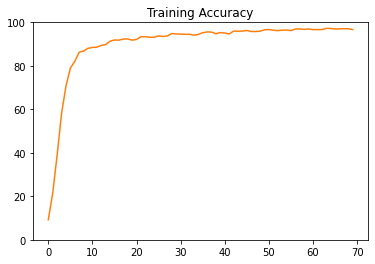

In [37]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(testAcc, color="tab:orange")
ax.set_ylim([0,100])
ax.set_title("Training Accuracy")
plt.show()

In [38]:
batch_size = 10
dataset = handwrittenCharsCornerDataset(X=conv_val_data, classToNum=invertedLabelDict)
cornerVal_dl = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)

In [39]:
valLoss = []
valAcc = []

for epoch in range(3):
  running_loss = 0
  running_acc = 0
  for i, data in enumerate(cornerVal_dl, 0):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    outputs = cornerConvModel(images)

    running_acc += findAccuracy(outputs, labels)

    running_loss += loss.item()
    if i % 1000 == 999:
      valLoss.append(running_loss)
      valAcc.append(running_acc/10)
      print("[%d, %5d] loss: %.5f acc: %.3f%%" % (epoch + 1, i + 1, running_loss / 1000, running_acc / 10))
      running_loss = 0
      running_acc = 0

print("Done!")

[1,  1000] loss: 0.00123 acc: 76.940%
[2,  1000] loss: 0.00123 acc: 77.500%
[3,  1000] loss: 0.00123 acc: 77.040%
Done!


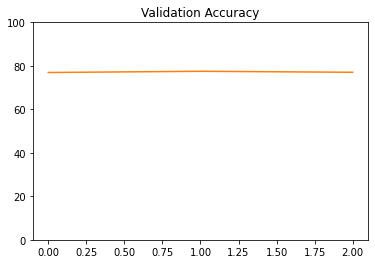

In [47]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(valAcc, color="tab:orange")
ax.set_ylim([0,100])
ax.set_title("Validation Accuracy")
plt.show()